In [1]:
!pip install psycopg2
!pip install pprint
import psycopg2 as pg
import pandas as pd
import numpy as np
from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())
import pandas.io.sql as pd_sql
import scipy.stats as st
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc, log_loss, roc_auc_score, f1_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from scipy.stats import sem
from collections import Counter
from matplotlib import pyplot
import seaborn as sns
%config InlineBackend.figure_formats = ['svg']


import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (9, 6)
sns.set(context = 'notebook', style = 'whitegrid', font_scale=1.2)

ERROR: Could not find a version that satisfies the requirement pprint (from versions: none)
ERROR: No matching distribution found for pprint


##  EDA (using sql): data features and target

In [2]:
connection_args = {
    'host' : 'localhost', 
    'dbname' : 'promotion',
    'port' : 5432
}
connection = pg.connect(**connection_args)
connection.autocommit = False

In [3]:
tr_query = 'SELECT * FROM promo_train;'
pd_sql.read_sql(tr_query, connection).head()
promo_tr = pd_sql.read_sql(tr_query, connection)
promo_tr.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,60,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,50,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,50,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,73,0


In [4]:
len(promo_tr)

54808

In [5]:
promo_tr.department.count()

54808

In [6]:
total = promo_tr.loc[promo_tr['department']=='Legal', 'is_promoted'].count()
total

1039

In [7]:
promo_tr.department.unique()

array(['Sales & Marketing', 'Operations', 'Technology', 'Analytics',
       'R&D', 'Procurement', 'Finance', 'HR', 'Legal'], dtype=object)

In [8]:
promo_tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54808 entries, 0 to 54807
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   employee_id           54808 non-null  int64  
 1   department            54808 non-null  object 
 2   region                54808 non-null  object 
 3   education             52399 non-null  object 
 4   gender                54808 non-null  object 
 5   recruitment_channel   54808 non-null  object 
 6   no_of_trainings       54808 non-null  int64  
 7   age                   54808 non-null  int64  
 8   previous_year_rating  50684 non-null  float64
 9   length_of_service     54808 non-null  int64  
 10  awards_won?           54808 non-null  int64  
 11  avg_training_score    54808 non-null  int64  
 12  is_promoted           54808 non-null  int64  
dtypes: float64(1), int64(7), object(5)
memory usage: 5.4+ MB


In [9]:
promo_tr.is_promoted.mean()

0.08517004816815063

<Figure size 2880x576 with 0 Axes>

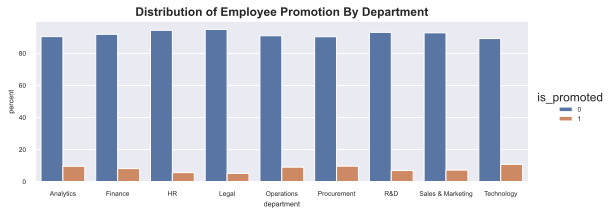

In [10]:
fig = plt.figure(figsize=(20,4),dpi=144)

df=promo_tr
x,y = 'department', 'is_promoted'
sns.set(font_scale=0.6)
(df
.groupby(x)[y]
.value_counts(normalize=True)
.mul(100)
.rename('percent')
.reset_index()
.pipe((sns.catplot,'data'), x=x,y='percent',hue=y, kind='bar', height =3, aspect = 2.5))
plt.title('Distribution of Employee Promotion By Department', fontsize=12, fontweight='bold')
#plt.tight_layout()
plt.subplots_adjust(top=0.9);

#plt.savefig('dept_distribution.pdf')


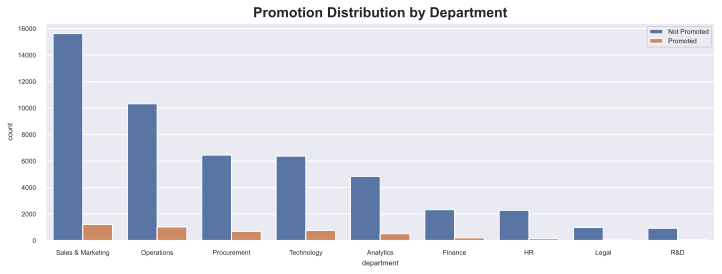

In [11]:
fig = plt.figure(figsize=(12,4),dpi=144)
#ax = fig.add_subplot(1,2,1)
sns.set(font_scale=0.6)
ax = sns.countplot(x='department', hue='is_promoted', data=promo_tr,
                  order = promo_tr['department'].value_counts().index)
plt.title('Promotion Distribution by Department', fontsize=14, fontweight='bold')
ax.set_xticklabels(ax.get_xticklabels())
handles, labels = ax.get_legend_handles_labels()
labels = ['Not Promoted','Promoted']
ax.legend(handles, labels, loc='upper right');

<Figure size 864x576 with 0 Axes>

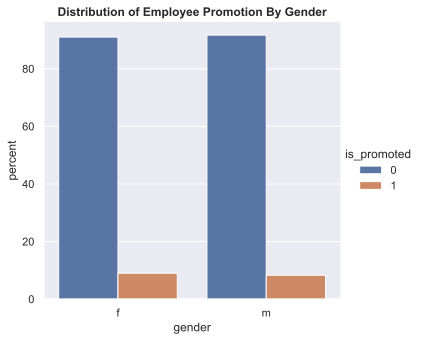

In [13]:
fig = plt.figure(figsize=(6,4),dpi=144)

df=promo_tr
x,y = 'gender', 'is_promoted'
sns.set(font_scale=1)
(df
.groupby(x)[y]
.value_counts(normalize=True)
.mul(100)
.rename('percent')
.reset_index()
.pipe((sns.catplot,'data'), x=x,y='percent',hue=y, kind='bar', height =5, aspect = 1))
plt.title('Distribution of Employee Promotion By Gender', fontsize=12, fontweight='bold')
plt.subplots_adjust(top=0.9)
#plt.tight_layout();

#plt.savefig('gender_distribution.pdf')

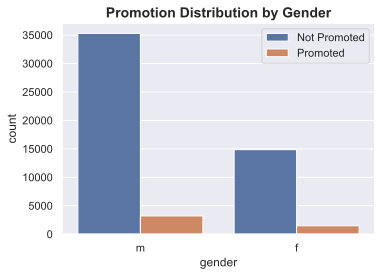

In [14]:
fig = plt.figure(figsize=(10,4),dpi=144)
ax = fig.add_subplot(1,2,1)

ax = sns.countplot(x='gender', hue='is_promoted',
                   data=promo_tr, order = promo_tr['gender'].value_counts().index)
plt.title('Promotion Distribution by Gender', fontsize=14, fontweight='bold')
ax.set_xticklabels(ax.get_xticklabels())
handles, labels = ax.get_legend_handles_labels()
labels = ['Not Promoted','Promoted']
ax.legend(handles, labels, loc='upper right')

plt.tight_layout()

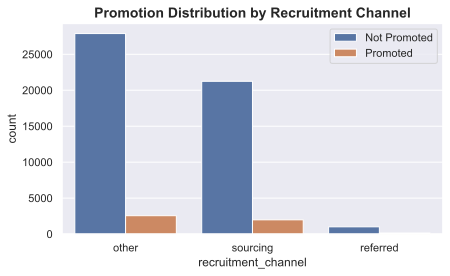

In [15]:
fig = plt.figure(figsize=(12,4),dpi=144)
ax = fig.add_subplot(1,2,1)

ax = sns.countplot(x='recruitment_channel', hue='is_promoted', data=promo_tr,
                   order = promo_tr['recruitment_channel'].value_counts().index)
plt.title('Promotion Distribution by Recruitment Channel', fontsize=14, fontweight='bold')
ax.set_xticklabels(ax.get_xticklabels())
handles, labels = ax.get_legend_handles_labels()
labels = ['Not Promoted','Promoted']
ax.legend(handles, labels, loc='upper right')
plt.tight_layout()

In [ ]:
fig = plt.figure(figsize=(6,4),dpi=144)

df=promo_tr
x,y = 'recruitment_channel', 'is_promoted'
sns.set(font_scale=1)
(df
.groupby(x)[y]
.value_counts(normalize=True)
.mul(100)
.rename('percent')
.reset_index()
.pipe((sns.catplot,'data'), x=x,y='percent',hue=y, kind='bar', height =5, aspect = 1))
plt.title('Distribution of Employee Promotion \n By Recruitment Channel', fontsize=12, fontweight='bold')
plt.subplots_adjust(top=0.9)
#plt.tight_layout();

#plt.savefig('recruitment_distribution.pdf')

In [16]:
query = 'SELECT * FROM promo_test;'
pd_sql.read_sql(query, connection).head()
promo_te = pd_sql.read_sql(query, connection)
#promo_te.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,awards_won?,avg_training_score
0,8724,Technology,region_26,Bachelor's,m,sourcing,1,24,NaN,1,0,77
1,74430,HR,region_4,Bachelor's,f,other,1,31,3.0,5,0,51
2,72255,Sales & Marketing,region_13,Bachelor's,m,other,1,31,1.0,4,0,47
3,38562,Procurement,region_2,Bachelor's,f,other,3,31,2.0,9,0,65
4,64486,Finance,region_29,Bachelor's,m,sourcing,1,30,4.0,7,0,61


In [ ]:
#promo_te.info()

### department

In [17]:
query_emp = """
SELECT  department,  COUNT(DISTINCT employee_id) AS employee_total 
FROM promo_train GROUP BY promo_train.department;"""
dept_emp_df = pd_sql.read_sql(query_emp, connection)
dept_emp_df

,department,employee_total
0,Analytics,5352
1,Finance,2536
2,HR,2418
3,Legal,1039
4,Operations,11348
5,Procurement,7138
6,R&D,999
7,Sales & Marketing,16840
8,Technology,7138


In [18]:
query_department = """
SELECT department, is_promoted, 
COUNT(*) AS sub_total from promo_train GROUP BY department, is_promoted
ORDER BY department, is_promoted;
"""

dept_df = pd_sql.read_sql(query_department, connection)
dept_df

,department,is_promoted,sub_total
0,Analytics,0,4840
1,Analytics,1,512
2,Finance,0,2330
3,Finance,1,206
4,HR,0,2282
5,HR,1,136
6,Legal,0,986
7,Legal,1,53
8,Operations,0,10325
9,Operations,1,1023


In [19]:
promo_department = """
SELECT department, is_promoted, sub_total,
SUM(sub_total)
OVER (PARTITION BY department) AS sum_total,
CAST(sub_total AS DOUBLE PRECISION)/SUM(sub_total)
OVER (PARTITION BY department) AS percent_total
FROM dept_df
ORDER BY sum_total DESC;"""

promo_dept = pysqldf(promo_department)
promo_dept

,department,is_promoted,sub_total,sum_total,percent_total
0,Sales & Marketing,0,15627,16840,0.927969
1,Sales & Marketing,1,1213,16840,0.072031
2,Operations,0,10325,11348,0.909852
3,Operations,1,1023,11348,0.090148
4,Procurement,0,6450,7138,0.903614
5,Procurement,1,688,7138,0.096386
6,Technology,0,6370,7138,0.892407
7,Technology,1,768,7138,0.107593
8,Analytics,0,4840,5352,0.904335
9,Analytics,1,512,5352,0.095665


Notice that promotion averages in HR and Legal departments are lower compared to other departments.

### education

In [20]:
query_education = """
SELECT education, is_promoted, 
COUNT(*) AS sub_total from promo_train GROUP BY education, is_promoted
ORDER BY education, is_promoted;
"""

edu_df = pd_sql.read_sql(query_education, connection)
edu_df

,education,is_promoted,sub_total
0,Bachelor's,0,33661
1,Bachelor's,1,3008
2,Below Secondary,0,738
3,Below Secondary,1,67
4,Master's & above,0,13454
5,Master's & above,1,1471
6,None,0,2287
7,None,1,122


In [21]:
promo_education = """
SELECT education, is_promoted, sub_total,
SUM(sub_total)
OVER (PARTITION BY education) AS sum_total,
CAST(sub_total AS DOUBLE PRECISION)/SUM(sub_total)
OVER (PARTITION BY education) AS percent_total
FROM edu_df
ORDER BY sum_total DESC;"""

promo_edu = pysqldf(promo_education)
promo_edu

,education,is_promoted,sub_total,sum_total,percent_total
0,Bachelor's,0,33661,36669,0.917969
1,Bachelor's,1,3008,36669,0.082031
2,Master's & above,0,13454,14925,0.901441
3,Master's & above,1,1471,14925,0.098559
4,None,0,2287,2409,0.949357
5,None,1,122,2409,0.050643
6,Below Secondary,0,738,805,0.916770
7,Below Secondary,1,67,805,0.083230


Not quite sure why there is None under education column. Does it mean employee without any education? Or could it be the education info was not available during data entry? As I'm not sure what does this mean, I am going to drop the None education rows. 

In [22]:
query="""
SELECT department, education, count(*) as sub_total
FROM promo_train
GROUP BY department, education
ORDER BY department, education;
"""
dept_edu = pd_sql.read_sql(query, connection)
dept_edu

,department,education,sub_total
0,Analytics,Bachelor's,3978
1,Analytics,Master's & above,1037
2,Analytics,None,337
3,Finance,Bachelor's,1895
4,Finance,Below Secondary,106
5,Finance,Master's & above,499
6,Finance,None,36
7,HR,Bachelor's,1525
8,HR,Below Secondary,128
9,HR,Master's & above,733


In [23]:
query="""
SELECT department, education, sub_total,
CAST(sub_total AS DOUBLE PRECISION)/SUM(sub_total)
OVER (PARTITION BY department) AS percent_total
FROM dept_edu
"""
dept_edu2 = pysqldf(query)
dept_edu2

,department,education,sub_total,percent_total
0,Analytics,Bachelor's,3978,0.743274
1,Analytics,Master's & above,1037,0.193759
2,Analytics,None,337,0.062967
3,Finance,Bachelor's,1895,0.747240
4,Finance,Below Secondary,106,0.041798
5,Finance,Master's & above,499,0.196767
6,Finance,None,36,0.014196
7,HR,Bachelor's,1525,0.630687
8,HR,Below Secondary,128,0.052936
9,HR,Master's & above,733,0.303143


### gender

In [24]:
query_gender = """
SELECT gender, is_promoted, 
COUNT(*) AS sub_total from promo_train GROUP BY gender, is_promoted
ORDER BY gender, is_promoted;
"""

gender_df = pd_sql.read_sql(query_gender, connection)
gender_df

,gender,is_promoted,sub_total
0,f,0,14845
1,f,1,1467
2,m,0,35295
3,m,1,3201


In [ ]:
promo_gend = """
SELECT gender, is_promoted, sub_total, 
SUM(sub_total)
OVER (PARTITION BY gender) AS sum_total,
CAST(sub_total AS DOUBLE PRECISION)/SUM(sub_total)
OVER (PARTITION BY gender) AS percent_total
FROM gender_df;"""

promo_gender = pysqldf(promo_gend)
promo_gender

I think the most important fact to check with gender is whether or not there was an indication irrelevant bias. Here the data show that the promotion rate is quite balanced between different genders, although male employee promotion was slightly below overall average. 

### region

In [25]:
query_region = """
SELECT region, is_promoted, 
COUNT(*) AS sub_total from promo_train GROUP BY region, is_promoted
ORDER BY region, is_promoted;
"""

region_df = pd_sql.read_sql(query_region, connection)
region_df

,region,is_promoted,sub_total
0,region_1,0,552
1,region_1,1,58
2,region_10,0,597
3,region_10,1,51
4,region_11,0,1241
...,...,...,...
63,region_7,1,516
64,region_8,0,602
65,region_8,1,53
66,region_9,0,412


In [26]:
promo_reg = """
SELECT region, is_promoted, sub_total, 
SUM(sub_total)
OVER (PARTITION BY region)AS sum_total,
CAST(sub_total AS DOUBLE PRECISION)/SUM(sub_total)
OVER (PARTITION BY region) AS percent_total
FROM region_df
ORDER BY sum_total DESC;"""

promo_region = pysqldf(promo_reg)
promo_region

,region,is_promoted,sub_total,sum_total,percent_total
0,region_2,0,11354,12343,0.919874
1,region_2,1,989,12343,0.080126
2,region_22,0,5694,6428,0.885812
3,region_22,1,734,6428,0.114188
4,region_7,0,4327,4843,0.893454
...,...,...,...,...,...
63,region_34,1,8,292,0.027397
64,region_33,0,259,269,0.962825
65,region_33,1,10,269,0.037175
66,region_18,0,30,31,0.967742


In [27]:
promo_reg1 = """
SELECT SUM(sub_total), SUM(sum_total), CAST(SUM(sub_total) AS FLOAT)/SUM(sum_total)
AS ave_promo
FROM promo_region
WHERE is_promoted = 1 AND sum_total > 600;
"""
region_1 = pysqldf(promo_reg1)
region_1

,SUM(sub_total),SUM(sum_total),ave_promo
0,4535,52031,0.08716


In [28]:
print(f"Average promoted employees in region more than 600 employees is {region_1.ave_promo[0]:.2%}")

Average promoted employees in region more than 600 employees is 8.72%


In [29]:
promo_reg2 = """
SELECT SUM(sub_total), SUM(sum_total), CAST(SUM(sub_total) AS FLOAT)/SUM(sum_total)
AS ave_promo
FROM promo_region
WHERE is_promoted = 1 AND sum_total <= 600;
"""
region_2 = pysqldf(promo_reg2)
region_2

,SUM(sub_total),SUM(sum_total),ave_promo
0,133,2777,0.047893


In [30]:
print(f"Average promoted employees in region with up to 600 employees is {region_2.ave_promo[0]:.2%}")

Average promoted employees in region with up to 600 employees is 4.79%


The percentage of promoted employees in regions with smaller number of employees is much lower with almost 4% difference! Was it because there was less opportunity for promotion due to smaller size? Or was it because the  fit-for-all promotion system was not adequate for smaller regions? I think it would be wiser not to build a fit-all model at it may  exacerbate the gap?

In [31]:
# The following regions will not be included.
query_reg = """
SELECT DISTINCT region, sum_total
FROM promo_region
WHERE sum_total <= 600;"""
region_3 = pysqldf(query_reg)
region_3

,region,sum_total
0,region_24,508
1,region_12,500
2,region_9,420
3,region_21,411
4,region_3,346
5,region_34,292
6,region_33,269
7,region_18,31


### recruitment channel

In [32]:
query_recruitment = """
SELECT recruitment_channel, is_promoted, 
COUNT(*) AS sub_total from promo_train GROUP BY recruitment_channel, is_promoted
ORDER BY recruitment_channel, sub_total;
"""

recr_df = pd_sql.read_sql(query_recruitment, connection)
recr_df

,recruitment_channel,is_promoted,sub_total
0,other,1,2556
1,other,0,27890
2,referred,1,138
3,referred,0,1004
4,sourcing,1,1974
5,sourcing,0,21246


In [33]:
promo_recruitment = """
SELECT recruitment_channel, is_promoted, sub_total, 
SUM(sub_total)
OVER (PARTITION BY recruitment_channel)AS sum_total,
CAST(sub_total AS DOUBLE PRECISION)/SUM(sub_total)
OVER (PARTITION BY recruitment_channel) AS percent_total
FROM recr_df
ORDER BY sum_total DESC;"""

promo_recr = pysqldf(promo_recruitment)
promo_recr

,recruitment_channel,is_promoted,sub_total,sum_total,percent_total
0,other,1,2556,30446,0.083952
1,other,0,27890,30446,0.916048
2,sourcing,1,1974,23220,0.085013
3,sourcing,0,21246,23220,0.914987
4,referred,1,138,1142,0.120841
5,referred,0,1004,1142,0.879159


The promotion rate for referred employee was much hier than the overall average. Does this data kind of confirming that that they were referred because they excelled at their work in the first place? Let's verify. 

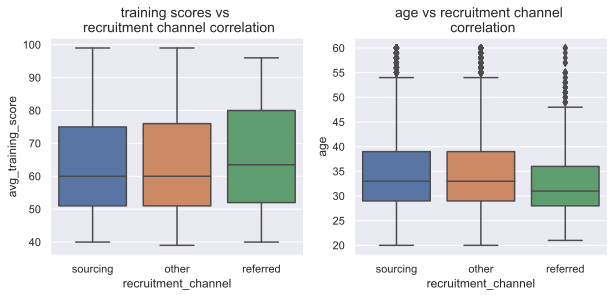

In [34]:
f,axes = plt.subplots(ncols = 2, figsize =(10,4))

sns.boxplot(x='recruitment_channel', y='avg_training_score', data = promo_tr, ax=axes[0])
axes[0].set_title("training scores vs \n recruitment channel correlation", fontsize=14)

sns.boxplot(x='recruitment_channel', y='age', data = promo_tr, ax=axes[1])
axes[1].set_title("age vs recruitment channel \n correlation", fontsize =14);

#plt.savefig('recruitment_corr.pdf')

In [ ]:
#fig, ax=plt.subplots(figsize=(6,4))
#ax = sns.boxplot(x='recruitment_channel', y='age', data = promo_tr)
#ax.set_title("age vs recruitment channel \n correlation", fontsize =12)
#plt.savefig('recrxage_corr.pdf')

In [ ]:
#fig, ax=plt.subplots(figsize=(6,4))
#ax = sns.boxplot(x='recruitment_channel', y='avg_training_score', data = promo_tr)
#ax.set_title("age vs recruitment channel \n correlation", fontsize =12)
#plt.savefig('recrxscores_corr.pdf')

Referred employees did indeed better during training and have a higher training average scores. They are also bit younger in average.

### age

In [35]:
query_age = """
SELECT age, is_promoted, 
COUNT(*) AS sub_total from promo_train GROUP BY age, is_promoted
ORDER BY age, sub_total;
"""

age_df = pd_sql.read_sql(query_age, connection)
age_df

,age,is_promoted,sub_total
0,20,1,4
1,20,0,109
2,21,1,5
3,21,0,93
4,22,1,18
...,...,...,...
77,58,0,197
78,59,1,17
79,59,0,192
80,60,1,14


In [36]:
age_promo = """
SELECT age, is_promoted, sub_total, 
SUM(sub_total)
OVER (PARTITION BY age)AS sum_total,
CAST(sub_total AS DOUBLE PRECISION)/SUM(sub_total)
OVER (PARTITION BY age) AS percent_total
FROM age_df
ORDER BY age;"""

promo_age = pysqldf(age_promo)
promo_age

,age,is_promoted,sub_total,sum_total,percent_total
0,20,1,4,113,0.035398
1,20,0,109,113,0.964602
2,21,1,5,98,0.051020
3,21,0,93,98,0.948980
4,22,1,18,231,0.077922
...,...,...,...,...,...
77,58,0,197,213,0.924883
78,59,1,17,209,0.081340
79,59,0,192,209,0.918660
80,60,1,14,217,0.064516


Low promotion rates for 20, 21 and 60 years old.

## Data Preprocessing


In [37]:
#promo_tr.to_csv('/Users/carlamoestafa/Documents/GitHub/project-3/data/promo_train.csv')

In [38]:
datafile = './data/promo_train.csv'
df_tr = pd.read_csv(datafile, index_col=0)

In [ ]:
#df_tr.info()

In [39]:
df_tr.rename(columns={'recruitement_channel':'recruitment', 'no_of_trainings':'trainings',
                     'previous_year_rating':'rating', 'length_of_service': 'serv_years',
                     'awards_won?':'awards', 'avg_training_score':'tr_scores'},
             inplace=True )
df_tr.head(2)

,employee_id,department,region,education,gender,recruitment_channel,trainings,age,rating,serv_years,awards,tr_scores,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,60,0


In [40]:
df_tr=df_tr[-df_tr['region'].isin(['region_24','region_12','region_9','region_21','region_3',
                              'region_33', 'region_34', 'region_18'])]

In [41]:
df_tr.education=df_tr.education.fillna(0)

In [42]:
df_tr.drop(df_tr[df_tr['education']==0].index, inplace = True)

In [43]:
df_tr.rating=df_tr.rating.fillna(0)

#### Converting Categorical Features

In [44]:
train_df = pd.get_dummies(df_tr, columns=["department", "education", "gender", "recruitment_channel"])

In [45]:
train_df.drop(columns=['department_Operations','education_Below Secondary', 'gender_m','recruitment_channel_other'],
             inplace = True)

In [46]:
train_df.rename(columns={"department_Analytics":"dept_analytics",
                     "department_Finance":"dept_finance",
                     "department_HR":"dept_HR","department_Legal":"dept_legal",
                     "department_Procurement":"dept_procurement",
                     "department_R&D":"dept_R&D",
                     "department_Technology":"dept_technology",
                     "department_Sales & Marketing":"dept_sales&marketing",
                     "education_Bachelor's":"bachelor_degree",
                     "education_Master's & above":"masters_degree", 
                     "recruitment_channel_referred":"recruitment_referred",
                     "recruitment_channel_sourcing":"recruitment_sourcing",
                     "is_promoted":"promoted"}, inplace=True )

In [47]:
selected_df= train_df.loc[:,['promoted','gender_f','age','serv_years', 'trainings', 'tr_scores', 'rating', 
                             'awards','dept_analytics','dept_finance', 'dept_HR', 'dept_legal','dept_procurement',
                             'dept_R&D', 'dept_sales&marketing', 'dept_technology', 'bachelor_degree',
                             'masters_degree','recruitment_referred', 'recruitment_sourcing']]

In [ ]:
#selected_df.info()

### Non cross-validated  train & test on  the entire  dataset train/test  split

In [48]:
X = selected_df.loc[:,['gender_f', 'age', 'serv_years', 'trainings', 'tr_scores', 'rating', 'awards',
                       'dept_analytics','dept_finance', 'dept_HR', 'dept_legal','dept_procurement','dept_R&D',
                       'dept_sales&marketing', 'dept_technology', 'bachelor_degree','masters_degree',
                       'recruitment_sourcing', 'recruitment_referred']]
y = selected_df['promoted']

In [49]:
selected_df.promoted.value_counts()

0    45270
1     4413
Name: promoted, dtype: int64

### Train/Test Split and hold out Test dataset for testing after cross validation 

Split the data between Train dataset and Test dataset.
The Train dataset will be under and/or oversampling for the cross validation. The Test dataset will be used to test the selected model from cross validation.

In [50]:
std_df = selected_df.copy()
X = std_df.drop('promoted', axis = 1)
y = std_df['promoted']

In [51]:
# This is Train/(holdout) Test data split before standard/scaling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [52]:
df_train = pd.concat([X_train, y_train], axis = 1)

In [53]:
df_test = pd.concat([X_test, y_test], axis = 1)

In [54]:
sc_tr_df = X_train.copy()

In [55]:
scaler = StandardScaler()

In [56]:
sc_tr_df['sc_age'] = scaler.fit_transform(sc_tr_df['age'].values.reshape(-1, 1))

In [57]:
sc_tr_df['sc_serv_years'] = scaler.fit_transform(sc_tr_df['serv_years'].values.reshape(-1, 1))

In [58]:
sc_tr_df['sc_training'] = scaler.fit_transform(sc_tr_df['trainings'].values.reshape(-1, 1))

In [59]:
sc_tr_df['sc_tr_scores'] = scaler.fit_transform(sc_tr_df['tr_scores'].values.reshape(-1, 1))

In [60]:
sc_tr_df['sc_rating'] = scaler.fit_transform(sc_tr_df['rating'].values.reshape(-1, 1))

In [61]:
sc_tr_df.drop(columns=['age','serv_years', 'trainings', 'tr_scores', 'rating'], inplace = True)

In [62]:
X_tr = sc_tr_df.copy()

In [63]:
y_tr = df_train['promoted']

In [64]:
lm = LogisticRegression()

In [65]:
lm.fit(X_tr, y_tr)

LogisticRegression()

In [66]:
sc_te_df = X_test.copy()  

In [67]:
sc_te_df['sc_age'] = scaler.fit_transform(sc_te_df['age'].values.reshape(-1, 1))

In [68]:
sc_te_df['sc_serv_years'] = scaler.fit_transform(sc_te_df['serv_years'].values.reshape(-1, 1))

In [69]:
sc_te_df['sc_training'] = scaler.fit_transform(sc_te_df['trainings'].values.reshape(-1, 1))

In [70]:
sc_te_df['sc_tr_scores'] = scaler.fit_transform(sc_te_df['tr_scores'].values.reshape(-1, 1))

In [71]:
sc_te_df['sc_rating'] = scaler.fit_transform(sc_te_df['rating'].values.reshape(-1, 1))

In [72]:
sc_te_df.drop(columns=['age','serv_years', 'trainings', 'tr_scores', 'rating'], inplace = True)

In [73]:
X_te = sc_te_df.copy()

In [74]:
y_te = df_test['promoted']

In [75]:
# Making a train dataset incl. features & target that will be used for cross validation.
cv_data = pd.concat([X_tr, y_tr], axis = 1)

#### Train & test on the entire dataset

In [76]:
LR = LogisticRegression(solver = 'newton-cg', C= 100000)
LR.fit(X, y)
y_pred = LR.predict(X)
print(f"Logistic Regression accuracy: {metrics.accuracy_score(y, y_pred):.3f}")

Logistic Regression accuracy: 0.936


#### Train and test on  entire  dataset on  train/test split (before scaling)

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [78]:
lm1=LogisticRegression(solver='newton-cg', C=100)
lm1.fit(X_train, y_train)
y_pred=lm1.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[9063,   11],
       [ 606,  257]])

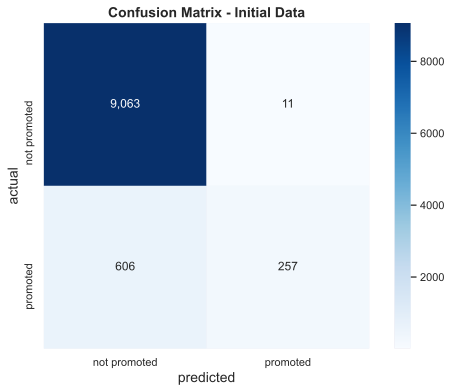

In [79]:
LR_confusion = confusion_matrix(y_test, y_pred)

plt.figure(dpi=150)
sns.heatmap(LR_confusion, cmap=plt.cm.Blues, annot=True, square=True, 
            xticklabels=['not promoted','promoted'],
            yticklabels=['not promoted','promoted'],
            fmt = ",.0f");
plt.xlabel('predicted', fontsize = 14)
plt.ylabel('actual', fontsize = 14)
plt.title('Confusion Matrix - Initial Data', fontsize = 14, fontweight = 'bold');
#plt.savefig('cm_initial.pdf')

In [80]:
LogReg = lm1
y_pred=lm1.predict(X_test)
y_pred_proba = lm1.predict_proba(X_test)[:, 1]
[fpr, tpr, thr] = roc_curve(y_test, y_pred_proba);
print('Train/Test split results:')
print(LogReg.__class__.__name__+" accuracy     : %2.3f" % accuracy_score(y_test, y_pred))
print(LogReg.__class__.__name__+" precission   : %2.3f" % precision_score(y_test, y_pred))
print(LogReg.__class__.__name__+" auc score    : %2.3f" % auc(fpr, tpr))
print(LogReg.__class__.__name__+" recall score : %2.3f" % recall_score(y_test, y_pred))
print(LogReg.__class__.__name__+" F1 score     : %2.3f" % f1_score(y_test, y_pred))

#print(LogReg.__class__.__name__+" log_loss: %2.3f" % log_loss(y_test, y_pred))

Train/Test split results:
LogisticRegression accuracy     : 0.938
LogisticRegression precission   : 0.959
LogisticRegression auc score    : 0.770
LogisticRegression recall score : 0.298
LogisticRegression F1 score     : 0.454


In [81]:
def plot_roc(true, probas):
    auc = roc_auc_score(true, probas)
    
    plt.plot(fpr, tpr, marker=' ')
    plt.xlabel("False Positive Rate (1 - Specifity)", fontsize=14)
    plt.ylabel("True Positive Rate (Sensitivity)", fontsize = 14)
    plt.title(f"ROC Curve for Promoted Employees \n AUC = {round(auc, 3)}", fontsize = 14, fontweight='bold');

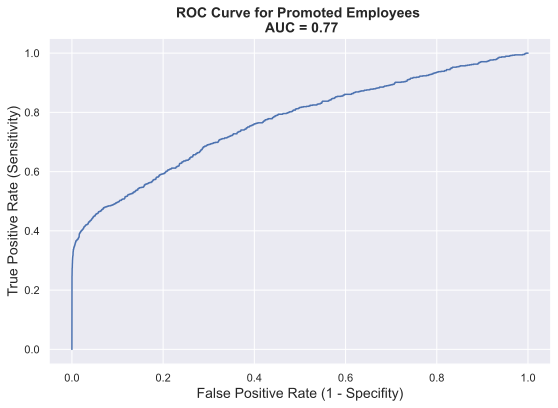

In [82]:
plot_roc(y_test, y_pred_proba )
#plt.savefig('auc_intital_data.pdf')

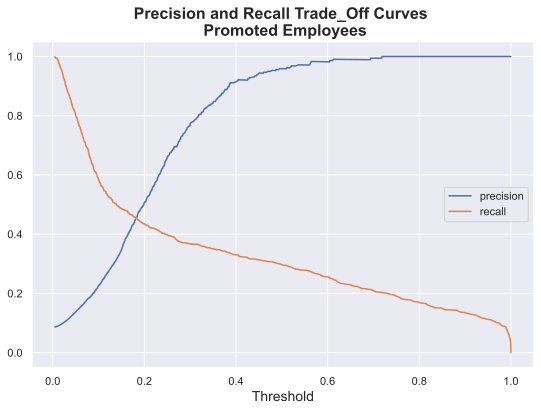

In [83]:
precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, lm1.predict_proba(X_test)[:,1])

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='center right')
plt.xlabel('Threshold', fontsize = 14);
plt.title('Precision and Recall Trade_Off Curves \n Promoted Employees', fontsize=16, fontweight='bold');
#plt.savefig("precision_recall.pdf")

The trade-off point is somewhere between threshold 0.15 - 0.2

In [84]:
def make_confusion_matrix(model, threshold = 0.15):
    y_predict = (model.predict_proba(X_test)[:,1] >= threshold)
    promotion_confusion = confusion_matrix(y_test, y_predict)
    plt.figure(dpi=80)
    sns.heatmap(promotion_confusion, cmap=plt.cm.Blues, annot = True,
                square=True, fmt='d',
                xticklabels =['not promoted', 'promoted'],
                yticklabels = ['not promoted', 'promoted']);
    plt.xlabel('prediction')
    plt.ylabel('actual')

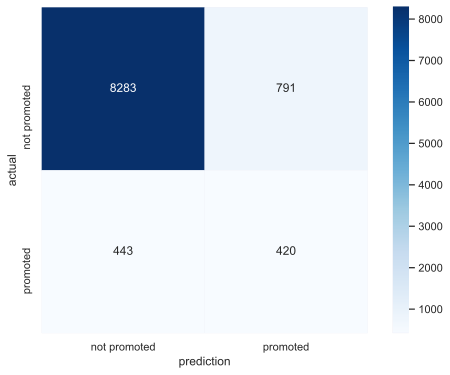

In [85]:
make_confusion_matrix(lm1, threshold = 0.15)

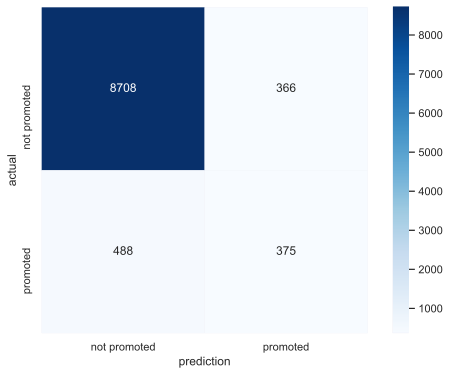

In [86]:
make_confusion_matrix(lm1, threshold = 0.2)

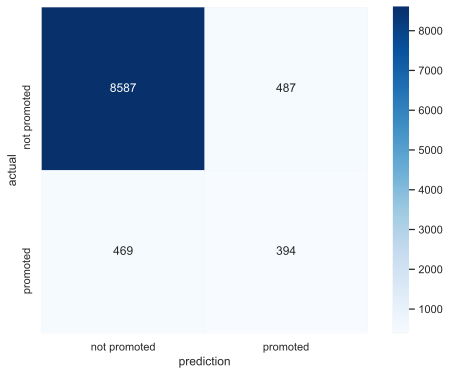

In [87]:
make_confusion_matrix(lm1, threshold = 0.18)

In [88]:
LogReg = lm1
y_pred=lm1.predict(X_test)
y_pred_proba = lm1.predict_proba(X_test)[:, 1] >= 0.18
[fpr, tpr, thr] = roc_curve(y_test, y_pred_proba);
print('Train/Test split results:')
print(LogReg.__class__.__name__+" accuracy     : %2.3f" % accuracy_score(y_test, y_pred_proba))
print(LogReg.__class__.__name__+" precission   : %2.3f" % precision_score(y_test, y_pred_proba))
print(LogReg.__class__.__name__+" auc score    : %2.3f" % auc(fpr, tpr))
print(LogReg.__class__.__name__+" recall score : %2.3f" % recall_score(y_test, y_pred_proba))
print(LogReg.__class__.__name__+" F1 score     : %2.3f" % f1_score(y_test, y_pred_proba))

Train/Test split results:
LogisticRegression accuracy     : 0.904
LogisticRegression precission   : 0.447
LogisticRegression auc score    : 0.701
LogisticRegression recall score : 0.457
LogisticRegression F1 score     : 0.452


At about the trade-off threshold of 0.18 there is still more than 50% of promoted employees classified as FN.

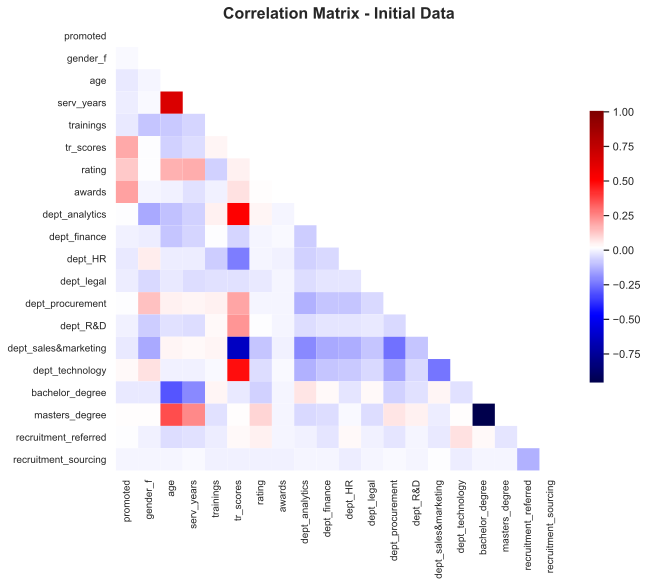

In [89]:
corr = selected_df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(10, 10))
    ax = sns.heatmap(corr, annot= False, mask=mask, vmax=1, square=True
                     , cmap='seismic',cbar_kws={"shrink": .5} )
    
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 10)    
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 10)

plt.title('Correlation Matrix - Initial Data', fontsize = 16, fontweight = 'bold')

#plt.savefig('intitial_data_corr.pdf')              
plt.show()   

Notice some strong correlations between features such as age, service years, bachelor degree, masters degree, trainings scores.

Text(0.5, 1.0, 'service years vs promoted \n Negative Correlation')

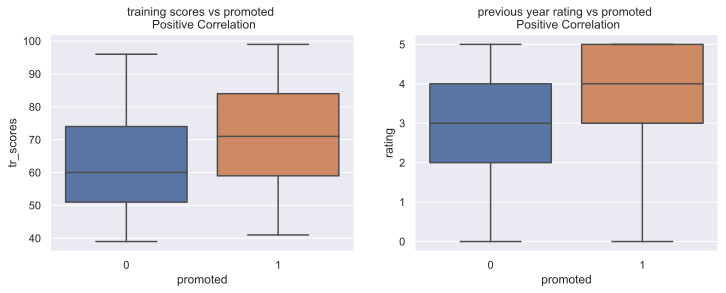

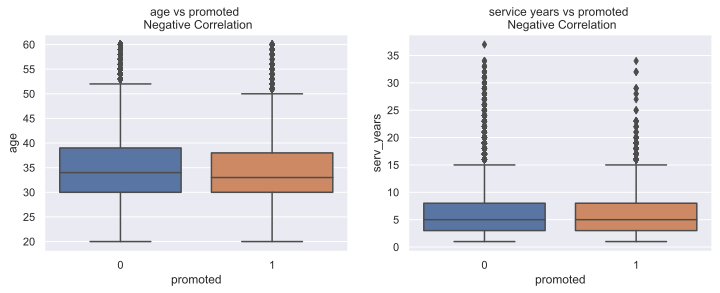

In [90]:
f,axes = plt.subplots(ncols = 2, figsize =(12,4))

sns.boxplot(x="promoted", y="tr_scores", data = selected_df, ax=axes[0])
axes[0].set_title("training scores vs promoted \n Positive Correlation")

sns.boxplot(x="promoted", y="rating", data = selected_df, ax=axes[1])
axes[1].set_title("previous year rating vs promoted \n Positive Correlation")

f,axes = plt.subplots(ncols = 2, figsize =(12,4))

sns.boxplot(x="promoted", y="age", data = selected_df, ax=axes[0])
axes[0].set_title("age vs promoted \n Negative Correlation")

sns.boxplot(x="promoted", y="serv_years", data = selected_df, ax=axes[1])
axes[1].set_title("service years vs promoted \n Negative Correlation")

#plt.show()

### Resampling the Train Dataset

In [91]:
from sklearn.utils import resample

#### Random oversampling

In [92]:
df = cv_data.copy()       # this is the scaled train data

Xtempo = cv_data.drop('promoted', axis = 1)
ytempo = cv_data['promoted']

Oversamplete the train data only.

In [93]:
X_cvtr, X_cvte, y_cvtr, y_cvte = train_test_split(Xtempo, ytempo, test_size=0.2, random_state=42)

In [94]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state = 0)
X_resampled, y_resampled = ros.fit_sample(X_cvtr,y_cvtr)

In [95]:
X_resampled.shape

(57876, 19)

In [96]:
Counter(y_resampled)

Counter({0: 28938, 1: 28938})

In [97]:
X_ros_tr, X_ros_te, y_ros_tr, y_ros_te = train_test_split(X_resampled, y_resampled, test_size = 0.2, random_state = 42)

In [98]:
lm2=LogisticRegression()

In [99]:
lm2.fit(X_ros_tr, y_ros_tr)
y_pred = lm2.predict(X_ros_te)
confusion_matrix(y_ros_te, y_pred)

array([[4478, 1292],
       [2262, 3544]])

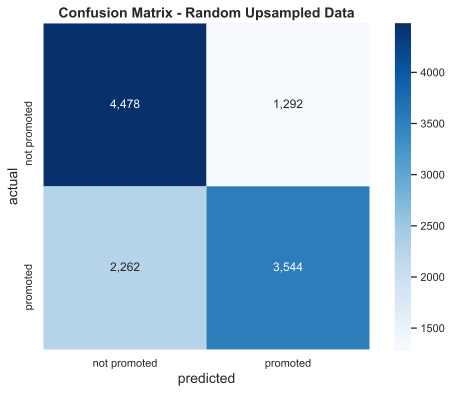

In [100]:
lm2_confusion = confusion_matrix(y_ros_te, y_pred)

plt.figure(dpi=150)
sns.heatmap(lm2_confusion, cmap=plt.cm.Blues, annot=True, square=True, 
            xticklabels=['not promoted','promoted'],
            yticklabels=['not promoted','promoted'],
            fmt = ",.0f");
plt.xlabel('predicted', fontsize = 14)
plt.ylabel('actual', fontsize = 14)
plt.title('Confusion Matrix - Random Upsampled Data', fontsize = 14, fontweight = 'bold');
#plt.savefig('cm_upsampled.pdf')

In [101]:
LogReg = lm2
y_pred=lm2.predict(X_ros_te)
y_pred_proba = LogReg.predict_proba(X_ros_te)[:, 1]
[fpr, tpr, thr] = roc_curve(y_ros_te, y_pred_proba);
print('Train/Test split results:')
print(LogReg.__class__.__name__+" accuracy     : %2.3f" % accuracy_score(y_ros_te, y_pred))
print(LogReg.__class__.__name__+" precission   : %2.3f" % precision_score(y_ros_te, y_pred))
print(LogReg.__class__.__name__+" auc score    : %2.3f" % auc(fpr, tpr))
print(LogReg.__class__.__name__+" recall score : %2.3f" % recall_score(y_ros_te, y_pred))
print(LogReg.__class__.__name__+" F1 score     : %2.3f" % f1_score(y_ros_te, y_pred))

Train/Test split results:
LogisticRegression accuracy     : 0.693
LogisticRegression precission   : 0.733
LogisticRegression auc score    : 0.761
LogisticRegression recall score : 0.610
LogisticRegression F1 score     : 0.666


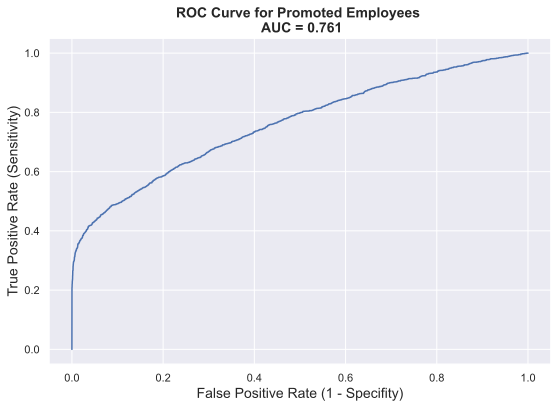

In [102]:
plot_roc(y_ros_te, y_pred_proba )
#plt.savefig('auc_ros_data.pdf')

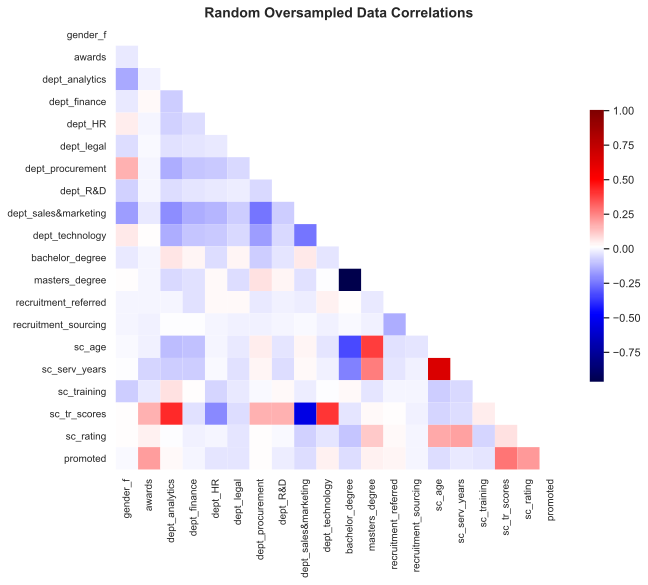

In [103]:
df_ros = pd.concat([X_resampled, y_resampled], axis=1)
corr = df_ros.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(10, 10))
    ax = sns.heatmap(corr, annot= False, mask=mask, vmax=1, square=True, cmap='seismic',cbar_kws={"shrink": .5} )
    

ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 10)    
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 10)

plt.title('Random Oversampled Data Correlations', fontsize = 14, fontweight = 'bold')

plt.savefig('resampled_corr.pdf')              
plt.show()

training scores, age and service years have strong correlations with some other features.

In [ ]:
#f,axes = plt.subplots(ncols = 2, figsize =(12,4))

#sns.boxplot(x="promoted", y="sc_tr_scores", data = df_ros, ax=axes[0])
#axes[0].set_title("training scores vs promoted \n Oversampled Data Correlation")

#sns.boxplot(x="promoted", y="sc_rating", data = df_ros, ax=axes[1])
#axes[1].set_title("previous year rating vs promoted \n Oversampled Data Correlation")

#f,axes = plt.subplots(ncols = 2, figsize =(12,4))

#sns.boxplot(x="promoted", y="sc_age", data = df_ros, ax=axes[0])
#axes[0].set_title("age vs promoted \n Overasampled Data Correlation")

#sns.boxplot(x="promoted", y="sc_serv_years", data = df_ros, ax=axes[1])
#axes[1].set_title("service years vs promoted \n Oversampled Data Correlation")

#plt.show()

## CV and   feature engineering /selection 

For the feature engineering/selection, I start by removing features that have strong correlaions with others to minimize multicolinearity and see the impact on the confusion matrix and recall score. If by dropping a feature the confusion matrix and/or the rrecall score improve, then the feature will be dropped. Otherwise it will be retained as a parameter. 

### KFold CV

In [104]:
df = df_ros.copy()

X0 = df.drop('promoted', axis = 1)
y0 = df['promoted']

In [105]:
model = LogisticRegression()
auc_scores = cross_val_score(model, X0, y0, cv = 10, scoring='roc_auc')
recall_scores = cross_val_score(model, X0,y0, cv=10, scoring ='recall')
f1_scores = cross_val_score(model, X0,y0, cv=10, scoring ='f1')
precision = cross_val_score(model, X0, y0, cv=10, scoring='precision')

nl = '\n'
print(f"The average cross validated scores:{nl}\
AUC        : {round(auc_scores.mean(),3)}{nl}\
Recall     : {round(recall_scores.mean(),3)}{nl}\
F1         : {round(f1_scores.mean(),3)}{nl}\
Precision  : {round(precision.mean(),3)}{nl}" )

X0_train, X0_val, y0_train, y0_val = train_test_split(X0, y0, test_size=0.2, random_state=42)
model.fit(X0_train, y0_train)
y0_pred = model.predict(X0_val)

model_confusion = confusion_matrix(y0_val, y0_pred )
print(f"Confusion matrix:{nl}{model_confusion}")

The average cross validated scores:
AUC        : 0.768
Recall     : 0.623
F1         : 0.672
Precision  : 0.728

Confusion matrix:
[[4478 1292]
 [2262 3544]]


In [106]:
# age has some strong correlations with some other features
df = df_ros.copy()
X1 = df.drop(['promoted', 'sc_age'], axis=1)
y1 = df['promoted']

In [107]:
model = LogisticRegression()
recall_scores = cross_val_score(model, X1,y1, cv=10, scoring ='recall' )
precision = cross_val_score(model, X1, y1, cv=10, scoring='precision')

nl = '\n'
print(f"The average cross validated scores:{nl}\
Recall     : {round(recall_scores.mean(),3)}{nl}\
Precision  : {round(precision.mean(),3)}{nl}" )

X1_train, X1_val, y1_train, y1_val = train_test_split(X1, y1, test_size=0.2, random_state=42)
model.fit(X1_train, y1_train)
y1_pred = model.predict(X1_val)

model_confusion = confusion_matrix(y1_val, y1_pred )
print(f"Confusion matrix:{nl}{model_confusion}")

The average cross validated scores:
Recall     : 0.619
Precision  : 0.729

Confusion matrix:
[[4468 1302]
 [2284 3522]]


The metrics worsoned. Must keep age.

In [108]:
#masters_degree has strong corr with age.
df = df_ros.copy()
X2 = df.drop(['promoted', 'masters_degree'], axis=1) 
y2 = df['promoted']

In [109]:
model = LogisticRegression()
recall_scores = cross_val_score(model, X2, y2, cv=10, scoring ='recall' )
precision = cross_val_score(model, X2, y2, cv=10, scoring='precision')

nl = '\n'
print(f"The average cross validated scores:{nl}\
Recall     : {round(recall_scores.mean(),3)}{nl}\
Precision  : {round(precision.mean(),3)}{nl}" )

X2_train, X2_val, y2_train, y2_val = train_test_split(X2, y2, test_size=0.2, random_state=2)
model.fit(X2_train, y2_train)
y2_pred = model.predict(X2_val)

model_confusion = confusion_matrix(y2_val, y2_pred )
print(f"Confusion matrix:{nl}{model_confusion}")

The average cross validated scores:
Recall     : 0.624
Precision  : 0.728

Confusion matrix:
[[4475 1349]
 [2107 3645]]


In [110]:
# bachelor_degree has strong corr with age.
df = df_ros.copy()
X3 = df.drop(['promoted', 'masters_degree', 'bachelor_degree'], axis=1) 
y3 = df['promoted']

In [111]:
model = LogisticRegression()
recall_scores = cross_val_score(model, X3, y3, cv=10, scoring ='recall' )
precision = cross_val_score(model, X3, y3, cv=10, scoring='precision')

nl = '\n'
print(f"The average cross validated scores:{nl}\
Recall     : {round(recall_scores.mean(),3)}{nl}\
Precision  : {round(precision.mean(),3)}{nl}" )

X3_train, X3_val, y3_train, y3_val = train_test_split(X3, y3, test_size=0.2, random_state=42)
model.fit(X3_train, y3_train)
y3_pred = model.predict(X3_val)

model_confusion = confusion_matrix(y3_val, y3_pred )
print(f"Confusion matrix:{nl}{model_confusion}")

The average cross validated scores:
Recall     : 0.616
Precision  : 0.726

Confusion matrix:
[[4462 1308]
 [2323 3483]]


Keeping bachelor_degree

In [112]:
#service years strong corr bachelor degreee
df = df_ros.copy()
X4 = df.drop(['promoted', 'masters_degree', 'sc_serv_years'], axis=1) 
y4 = df['promoted']

In [113]:
model = LogisticRegression()
recall_scores = cross_val_score(model, X4, y4, cv=10, scoring ='recall' )
precision = cross_val_score(model, X4, y4, cv=10, scoring='precision')

nl = '\n'
print(f"The average cross validated scores:{nl}\
Recall     : {round(recall_scores.mean(),3)}{nl}\
Precision  : {round(precision.mean(),3)}{nl}" )

X4_train, X4_val, y4_train, y4_val = train_test_split(X4, y4, test_size=0.2, random_state=42)
model.fit(X4_train, y4_train)
y4_pred = model.predict(X4_val)

model_confusion = confusion_matrix(y4_val, y4_pred )
print(f"Confusion matrix:{nl}{model_confusion}")

The average cross validated scores:
Recall     : 0.622
Precision  : 0.728

Confusion matrix:
[[4487 1283]
 [2274 3532]]


In [114]:
df = df_ros.copy()
X5 = df.drop(['promoted', 'masters_degree','gender_f'], axis=1) 
y5 = df['promoted']

In [115]:
model = LogisticRegression()

recall_scores = cross_val_score(model, X5, y5, cv=10, scoring ='recall' )
precision = cross_val_score(model, X5, y5, cv=10, scoring='precision')

nl = '\n'
print(f"The average cross validated scores:{nl}\
Recall     : {round(recall_scores.mean(),3)}{nl}\
Precision  : {round(precision.mean(),3)}{nl}" )

X5_train, X5_val, y5_train, y5_val = train_test_split(X5, y5, test_size=0.2, random_state=42)
model.fit(X5_train, y5_train)
y5_pred = model.predict(X5_val)

model_confusion = confusion_matrix(y5_val, y5_pred )
print(f"Confusion matrix:{nl}{model_confusion}")

The average cross validated scores:
Recall     : 0.624
Precision  : 0.729

Confusion matrix:
[[4478 1292]
 [2255 3551]]


Dropping gender_f decreased TP+FN. To keep.

In [116]:
df = df_ros.copy()
X6 = df.drop(['promoted', 'masters_degree','dept_analytics'], axis=1) 
y6 = df['promoted']

In [117]:
model = LogisticRegression()
recall_scores = cross_val_score(model, X6, y6, cv=10, scoring ='recall' )
precision = cross_val_score(model, X6, y6, cv=10, scoring='precision')

nl = '\n'
print(f"The average cross validated scores:{nl}\
Recall     : {round(recall_scores.mean(),3)}{nl}\
Precision  : {round(precision.mean(),3)}{nl}" )

X6_train, X6_val, y6_train, y6_val = train_test_split(X6, y6, test_size=0.2, random_state=42)
model.fit(X6_train, y6_train)
y6_pred = model.predict(X6_val)

model_confusion = confusion_matrix(y6_val, y6_pred )
print(f"Confusion matrix:{nl}{model_confusion}")

The average cross validated scores:
Recall     : 0.627
Precision  : 0.709

Confusion matrix:
[[4370 1400]
 [2201 3605]]


Dropping dept_analytics decreased TP. To keep.

In [118]:
df = df_ros.copy()
X7 = df.drop(['promoted', 'masters_degree', 'awards'], axis=1) 
y7 = df['promoted']

In [119]:
model = LogisticRegression()
recall_scores = cross_val_score(model, X7, y7, cv=10, scoring ='recall' )
precision = cross_val_score(model, X7, y7, cv=10, scoring='precision')

nl = '\n'
print(f"The average cross validated scores:{nl}\
Recall     : {round(recall_scores.mean(),3)}{nl}\
Precision  : {round(precision.mean(),3)}{nl}" )

X7_train, X7_val, y7_train, y7_val = train_test_split(X7, y7, test_size=0.2, random_state=42)
model.fit(X7_train, y7_train)
y7_pred = model.predict(X7_val)

model.confusion = confusion_matrix(y7_val, y7_pred )
print(f"Confusion matrix:{nl}{model_confusion}")

The average cross validated scores:
Recall     : 0.617
Precision  : 0.711

Confusion matrix:
[[4370 1400]
 [2201 3605]]


In [120]:
df = df_ros.copy()
X8 = df.drop(['promoted', 'masters_degree', 'dept_finance'], axis=1) 
y8 = df['promoted']

In [121]:
model = LogisticRegression()
recall_scores = cross_val_score(model, X8, y8, cv=10, scoring ='recall' )
precision = cross_val_score(model, X8, y8, cv=10, scoring='precision')

nl = '\n'
print(f"The average cross validated scores:{nl}\
Recall     : {round(recall_scores.mean(),3)}{nl}\
Precision  : {round(precision.mean(),3)}{nl}" )

X8_train, X8_val, y8_train, y8_val = train_test_split(X8, y8, test_size=0.2, random_state=42)
model.fit(X8_train, y8_train)
y8_pred = model.predict(X8_val)

model_confusion = confusion_matrix(y8_val, y8_pred )
print(f"Confusion matrix:{nl}{model_confusion}")

The average cross validated scores:
Recall     : 0.622
Precision  : 0.728

Confusion matrix:
[[4481 1289]
 [2265 3541]]


In [122]:
df = df_ros.copy()
X9 = df.drop(['promoted', 'masters_degree','dept_HR'], axis=1) 
y9 = df['promoted']

In [123]:
model = LogisticRegression()
recall_scores = cross_val_score(model, X9, y9, cv=10, scoring ='recall' )
precision = cross_val_score(model, X9, y9, cv=10, scoring='precision')

nl = '\n'
print(f"The average cross validated scores:{nl}\
Recall     : {round(recall_scores.mean(),3)}{nl}\
Precision  : {round(precision.mean(),3)}{nl}" )

X9_train, X9_val, y9_train, y9_val = train_test_split(X9, y9, test_size=0.2, random_state=42)
model.fit(X9_train, y9_train)
y9_pred = model.predict(X9_val)

model_confusion = confusion_matrix(y9_val, y9_pred )
print(f"Confusion matrix:{nl}{model_confusion}")

The average cross validated scores:
Recall     : 0.633
Precision  : 0.72

Confusion matrix:
[[4402 1368]
 [2200 3606]]


In [124]:
df = df_ros.copy()
X10 = df.drop(['promoted', 'masters_degree', 'dept_legal'], axis=1) 
y10 = df['promoted']

In [125]:
model = LogisticRegression()
recall_scores = cross_val_score(model, X10, y10, cv=10, scoring ='recall' )
precision = cross_val_score(model, X10, y10, cv=10, scoring='precision')

nl = '\n'
print(f"The average cross validated scores:{nl}\
Recall     : {round(recall_scores.mean(),3)}{nl}\
Precision  : {round(precision.mean(),3)}{nl}" )

X10_train, X10_val, y10_train, y10_val = train_test_split(X10, y10, test_size=0.2, random_state=42)
model.fit(X10_train, y10_train)
y10_pred = model.predict(X10_val)

model_confusion = confusion_matrix(y10_val, y10_pred )
print(f"Confusion matrix:{nl}{model_confusion}")

The average cross validated scores:
Recall     : 0.623
Precision  : 0.728

Confusion matrix:
[[4487 1283]
 [2279 3527]]


In [126]:
df = df_ros.copy()
X11 = df.drop(['promoted', 'masters_degree', 'dept_procurement'],axis=1) 
y11 = df['promoted']

In [127]:
model = LogisticRegression()
recall_scores = cross_val_score(model, X11, y11, cv=10, scoring ='recall' )
precision = cross_val_score(model, X11, y11, cv=10, scoring='precision')

nl = '\n'
print(f"The average cross validated scores:{nl}\
Recall     : {round(recall_scores.mean(),3)}{nl}\
Precision  : {round(precision.mean(),3)}{nl}" )

X11_train, X11_val, y11_train, y11_val = train_test_split(X11, y11, test_size=0.2, random_state=42)
model.fit(X11_train, y11_train)
y11_pred = model.predict(X11_val)

model_confusion = confusion_matrix(y11_val, y11_pred )
print(f"Confusion matrix:{nl}{model_confusion}")

The average cross validated scores:
Recall     : 0.633
Precision  : 0.713

Confusion matrix:
[[4344 1426]
 [2198 3608]]


In [128]:
df = df_ros.copy()
X12 = df.drop(['promoted', 'masters_degree', 'dept_R&D'], axis=1) 
y12 = df['promoted']

In [129]:
model = LogisticRegression()
recall_scores = cross_val_score(model, X12, y12, cv=10, scoring ='recall' )
precision = cross_val_score(model, X12, y12, cv=10, scoring='precision')

nl = '\n'
print(f"The average cross validated scores:{nl}\
Recall     : {round(recall_scores.mean(),3)}{nl}\
Precision  : {round(precision.mean(),3)}{nl}" )

X12_train, X12_val, y12_train, y12_val = train_test_split(X12, y12, test_size=0.2, random_state=42)
model.fit(X12_train, y12_train)
y12_pred = model.predict(X12_val)

model_confusion = confusion_matrix(y12_val, y12_pred )
print(f"Confusion matrix:{nl}{model_confusion}")

The average cross validated scores:
Recall     : 0.623
Precision  : 0.731

Confusion matrix:
[[4505 1265]
 [2260 3546]]


In [130]:
df = df_ros.copy()
X13 = df.drop(['promoted', 'masters_degree','dept_sales&marketing'], axis=1) 
y13 = df['promoted']

In [131]:
model = LogisticRegression()
recall_scores = cross_val_score(model, X13, y13, cv=10, scoring ='recall' )
precision = cross_val_score(model, X13, y13, cv=10, scoring='precision')

nl = '\n'
print(f"The average cross validated scores:{nl}\
Recall     : {round(recall_scores.mean(),3)}{nl}\
Precision  : {round(precision.mean(),3)}{nl}" )

X13_train, X13_val, y13_train, y13_val = train_test_split(X13, y13, test_size=0.2, random_state=42)
model.fit(X13_train, y13_train)
y13_pred = model.predict(X13_val)

model_confusion = confusion_matrix(y13_val, y13_pred )
print(f"Confusion matrix:{nl}{model_confusion}")

The average cross validated scores:
Recall     : 0.634
Precision  : 0.694

Confusion matrix:
[[4165 1605]
 [2162 3644]]


In [132]:
df = df_ros.copy()
X14 = df.drop(['promoted', 'masters_degree', 'dept_technology'], axis=1) 
y14 = df['promoted']

In [133]:
model = LogisticRegression()
recall_scores = cross_val_score(model, X14, y14, cv=10, scoring ='recall' )
precision = cross_val_score(model, X14, y14, cv=10, scoring='precision')

nl = '\n'
print(f"The average cross validated scores:{nl}\
Recall     : {round(recall_scores.mean(),3)}{nl}\
Precision  : {round(precision.mean(),3)}{nl}" )

X14_train, X14_val, y14_train, y14_val = train_test_split(X14, y14, test_size=0.2, random_state=42)
model.fit(X14_train, y14_train)
y14_pred = model.predict(X14_val)

model_confusion = confusion_matrix(y14_val, y14_pred )
print(f"Confusion matrix:{nl}{model_confusion}")

The average cross validated scores:
Recall     : 0.635
Precision  : 0.705

Confusion matrix:
[[4277 1493]
 [2184 3622]]


In [134]:
df = df_ros.copy()
X15 = df.drop(['promoted', 'masters_degree', 'recruitment_referred'], axis=1) 
y15 = df['promoted']

In [135]:
model = LogisticRegression()
recall_scores = cross_val_score(model, X15, y15, cv=10, scoring ='recall' )
precision = cross_val_score(model, X15, y15, cv=10, scoring='precision')

nl = '\n'
print(f"The average cross validated scores:{nl}\
Recall     : {round(recall_scores.mean(),3)}{nl}\
Precision  : {round(precision.mean(),3)}{nl}" )

X15_train, X15_val, y15_train, y15_val = train_test_split(X15, y15, test_size=0.2, random_state=42)
model.fit(X15_train, y15_train)
y15_pred = model.predict(X15_val)

model_confusion = confusion_matrix(y15_val, y15_pred )
print(f"Confusion matrix:{nl}{model_confusion}")

The average cross validated scores:
Recall     : 0.624
Precision  : 0.728

Confusion matrix:
[[4471 1299]
 [2273 3533]]


In [136]:
df = df_ros.copy()
X16 = df.drop(['promoted', 'masters_degree', 'recruitment_sourcing'], axis=1) 
y16 = df['promoted']

In [137]:
model = LogisticRegression()
recall_scores = cross_val_score(model, X16, y16, cv=10, scoring ='recall' )
precision = cross_val_score(model, X16, y16, cv=10, scoring='precision')

nl = '\n'
print(f"The average cross validated scores:{nl}\
Recall     : {round(recall_scores.mean(),3)}{nl}\
Precision  : {round(precision.mean(),3)}{nl}" )

X16_train, X16_val, y16_train, y16_val = train_test_split(X16, y16, test_size=0.2, random_state=42)
model.fit(X16_train, y16_train)
y16_pred = model.predict(X16_val)

model_confusion = confusion_matrix(y16_val, y16_pred )
print(f"Confusion matrix:{nl}{model_confusion}")

The average cross validated scores:
Recall     : 0.624
Precision  : 0.728

Confusion matrix:
[[4480 1290]
 [2261 3545]]


In [138]:
df = df_ros.copy()
X17 = df.drop(['promoted', 'masters_degree', 'sc_training'], axis=1) 
y17 = df['promoted']

In [139]:
model = LogisticRegression()
recall_scores = cross_val_score(model, X17, y17, cv=10, scoring ='recall' )
precision = cross_val_score(model, X17, y17, cv=10, scoring='precision')

nl = '\n'
print(f"The average cross validated scores:{nl}\
Recall     : {round(recall_scores.mean(),3)}{nl}\
Precision  : {round(precision.mean(),3)}{nl}" )


X17_train, X17_val, y17_train, y17_val = train_test_split(X17, y17, test_size=0.2, random_state=42)
model.fit(X17_train, y17_train)
y17_pred = model.predict(X17_val)

model_confusion = confusion_matrix(y17_val, y17_pred )
print(f"Confusion matrix:{nl}{model_confusion}")

The average cross validated scores:
Recall     : 0.623
Precision  : 0.73

Confusion matrix:
[[4477 1293]
 [2289 3517]]


In [140]:
df = df_ros.copy()
X18 = df.drop(['promoted', 'masters_degree','sc_tr_scores'], axis=1) 
y18 = df['promoted']

In [141]:
model = LogisticRegression()
recall_scores = cross_val_score(model, X18, y18, cv=10, scoring ='recall' )
precision = cross_val_score(model, X18, y18, cv=10, scoring='precision')

nl = '\n'
print(f"The average cross validated scores:{nl}\
Recall     : {round(recall_scores.mean(),3)}{nl}\
Precision  : {round(precision.mean(),3)}{nl}" )


X18_train, X18_val, y18_train, y18_val = train_test_split(X18, y18, test_size=0.2, random_state=42)
model.fit(X18_train, y18_train)
y18_pred = model.predict(X18_val)

model_confusion = confusion_matrix(y18_val, y18_pred )
print(f"Confusion matrix:{nl}{model_confusion}")

The average cross validated scores:
Recall     : 0.603
Precision  : 0.626

Confusion matrix:
[[3742 2028]
 [2273 3533]]


In [142]:
df = df_ros.copy()
X19 = df.drop(['promoted', 'masters_degree','sc_rating'], axis=1) 
y19 = df['promoted']

In [143]:
model = LogisticRegression()
recall_scores = cross_val_score(model, X19, y19, cv=10, scoring ='recall' )
precision = cross_val_score(model, X19, y19, cv=10, scoring='precision')

nl = '\n'
print(f"The average cross validated scores:{nl}\
Recall     : {round(recall_scores.mean(),3)}{nl}\
Precision  : {round(precision.mean(),3)}{nl}" )

X19_train, X19_val, y19_train, y19_val = train_test_split(X19, y19, test_size=0.2, random_state=42)
model.fit(X19_train, y19_train)
y19_pred = model.predict(X19_val)

model_confusion = confusion_matrix(y19_val, y19_pred )
print(f"Confusion matrix:{nl}{model_confusion}")

The average cross validated scores:
Recall     : 0.574
Precision  : 0.726

Confusion matrix:
[[4592 1178]
 [2619 3187]]


In [144]:
df = df_ros.copy()
X20 = df.drop(['promoted', 'masters_degree'], axis=1) 
y20 = df['promoted']
# added transformed feature(s):
X20['sq_training']=X20['sc_training']**2

In [145]:
model = LogisticRegression()
recall_scores = cross_val_score(model, X20, y20, cv=10, scoring ='recall' )
precision = cross_val_score(model, X20, y20, cv=10, scoring='precision')

nl = '\n'
print(f"The average cross validated scores:{nl}\
Recall     : {round(recall_scores.mean(),3)}{nl}\
Precision  : {round(precision.mean(),3)}{nl}" )

X20_train, X20_val, y20_train, y20_val = train_test_split(X20, y20, test_size=0.2, random_state=42)
model.fit(X20_train, y20_train)
y20_pred = model.predict(X20_val)

model_confusion = confusion_matrix(y20_val, y20_pred )
print(f"Confusion matrix:{nl}{model_confusion}")

The average cross validated scores:
Recall     : 0.625
Precision  : 0.728

Confusion matrix:
[[4482 1288]
 [2261 3545]]


In [146]:
df = df_ros.copy()
X21 = df.drop(['promoted', 'masters_degree'], axis=1) 
y21 = df['promoted']
# added transformed feature(s):
X21['sq_scores']=X21['sc_tr_scores']**2

In [147]:
model = LogisticRegression()
recall_scores = cross_val_score(model, X21, y21, cv=10, scoring ='recall' )
precision = cross_val_score(model, X21, y21, cv=10, scoring='precision')

nl = '\n'
print(f"The average cross validated scores:{nl}\
Recall     : {round(recall_scores.mean(),3)}{nl}\
Precision  : {round(precision.mean(),3)}{nl}" )

X21_train, X21_val, y21_train, y21_val = train_test_split(X21, y21, test_size=0.2, random_state=42)
model.fit(X21_train, y21_train)
y21_pred = model.predict(X21_val)

model_confusion = confusion_matrix(y21_val, y21_pred )
print(f"Confusion matrix:{nl}{model_confusion}")

The average cross validated scores:
Recall     : 0.62
Precision  : 0.73

Confusion matrix:
[[4495 1275]
 [2301 3505]]


In [148]:
df = df_ros.copy()
X22 = df.drop(['promoted', 'masters_degree'], axis=1) 
y22 = df['promoted']
# added transformed feature(s):
X22['sq_age']=X22['sc_age']**2

In [149]:
model = LogisticRegression()
recall_scores = cross_val_score(model, X22, y22, cv=10, scoring ='recall' )
precision = cross_val_score(model, X22, y22, cv=10, scoring='precision')

nl = '\n'
print(f"The average cross validated scores:{nl}\
Recall     : {round(recall_scores.mean(),3)}{nl}\
Precision  : {round(precision.mean(),3)}{nl}" )

X22_train, X22_val, y22_train, y22_val = train_test_split(X22, y22, test_size=0.2, random_state=42)
model.fit(X22_train, y22_train)
y22_pred = model.predict(X22_val)

model_confusion = confusion_matrix(y22_val, y22_pred )
print(f"Confusion matrix:{nl}{model_confusion}")

The average cross validated scores:
Recall     : 0.624
Precision  : 0.728

Confusion matrix:
[[4479 1291]
 [2258 3548]]


In [150]:
df = df_ros.copy()
X23 = df.drop(['promoted', 'masters_degree'], axis=1) 
y23 = df['promoted']
# added transformed feature(s):
X23['sq_rating']=X23['sc_rating']**2

In [151]:
model = LogisticRegression()
recall_scores = cross_val_score(model, X23, y23, cv=10, scoring ='recall' )
precision = cross_val_score(model, X23, y23, cv=10, scoring='precision')

nl = '\n'
print(f"The average cross validated scores:{nl}\
Recall     : {round(recall_scores.mean(),3)}{nl}\
Precision  : {round(precision.mean(),3)}{nl}" )

X23_train, X23_val, y23_train, y23_val = train_test_split(X23, y23, test_size=0.2, random_state=42)
model.fit(X23_train, y23_train)
y23_pred = model.predict(X23_val)

model_confusion = confusion_matrix(y23_val, y23_pred )
print(f"Confusion matrix:{nl}{model_confusion}")

The average cross validated scores:
Recall     : 0.64
Precision  : 0.741

Confusion matrix:
[[4493 1277]
 [2214 3592]]


In [152]:
df = df_ros.copy()
X24 = df.drop(['promoted', 'masters_degree'], axis=1) 
y24 = df['promoted']
# added transformed feature(s):
X24['masters_sq']=X0['masters_degree']**2

In [153]:
model = LogisticRegression()
recall_scores = cross_val_score(model, X24, y24, cv=10, scoring ='recall' )
precision = cross_val_score(model, X24, y24, cv=10, scoring='precision')

nl = '\n'
print(f"The average cross validated scores:{nl}\
Recall     : {round(recall_scores.mean(),3)}{nl}\
Precision  : {round(precision.mean(),3)}{nl}" )

X24_train, X24_val, y24_train, y24_val = train_test_split(X24, y24, test_size=0.2, random_state=42)
model.fit(X24_train, y24_train)
y24_pred = model.predict(X24_val)

model_confusion = confusion_matrix(y24_val, y24_pred )
print(f"Confusion matrix:{nl}{model_confusion}")

The average cross validated scores:
Recall     : 0.623
Precision  : 0.728

Confusion matrix:
[[4478 1292]
 [2262 3544]]


In [154]:
df = df_ros.copy()
X25 = df.drop(['promoted', 'masters_degree'], axis=1) 
y25 = df['promoted']
# added transformed feature(s):
X25['sq_awards']=X25['awards']**2

In [155]:
model = LogisticRegression()
recall_scores = cross_val_score(model, X25, y25, cv=10, scoring ='recall' )
precision = cross_val_score(model, X25, y25, cv=10, scoring='precision')

nl = '\n'
print(f"The average cross validated scores:{nl}\
Recall     : {round(recall_scores.mean(),3)}{nl}\
Precision  : {round(precision.mean(),3)}{nl}" )

X25_train, X25_val, y25_train, y25_val = train_test_split(X25, y25, test_size=0.2, random_state=42)
model.fit(X25_train, y25_train)
y25_pred = model.predict(X25_val)

model_confusion = confusion_matrix(y25_val, y25_pred )
print(f"Confusion matrix:{nl}{model_confusion}")

The average cross validated scores:
Recall     : 0.624
Precision  : 0.728

Confusion matrix:
[[4482 1288]
 [2263 3543]]


In [156]:
df = df_ros.copy()
X26 = df.drop(['promoted','masters_degree'], axis=1) 
y26 = df['promoted']
# added transformed feature(s):
X26['sq_gender']=X26['gender_f']**2

In [157]:
model = LogisticRegression()
recall_scores = cross_val_score(model, X26, y26, cv=10, scoring ='recall' )
precision = cross_val_score(model, X26, y26, cv=10, scoring='precision')

nl = '\n'
print(f"The average cross validated scores:{nl}\
Recall     : {round(recall_scores.mean(),3)}{nl}\
Precision  : {round(precision.mean(),3)}{nl}" )

X26_train, X26_val, y26_train, y26_val = train_test_split(X26, y26, test_size=0.2, random_state=42)
model.fit(X26_train, y26_train)
y26_pred = model.predict(X26_val)

model_confusion = confusion_matrix(y26_val, y26_pred )
print(f"Confusion matrix:{nl}{model_confusion}")

The average cross validated scores:
Recall     : 0.624
Precision  : 0.728

Confusion matrix:
[[4482 1288]
 [2263 3543]]


In [158]:
df = df_ros.copy()
X27 = df.drop(['promoted', 'masters_degree'], axis=1) 
y27 = df['promoted']
# added transformed feature(s):
X27['sq_serv_years']=X27['sc_serv_years']**2 

In [159]:
model = LogisticRegression()
recall_scores = cross_val_score(model, X27, y27, cv=10, scoring ='recall' )
precision = cross_val_score(model, X27, y27, cv=10, scoring='precision')

nl = '\n'
print(f"The average cross validated scores:{nl}\
Recall     : {round(recall_scores.mean(),3)}{nl}\
Precision  : {round(precision.mean(),3)}{nl}" )

X27_train, X27_val, y27_train, y27_val = train_test_split(X27, y27, test_size=0.2, random_state=42)
model.fit(X27_train, y27_train)
y27_pred = model.predict(X27_val)

model_confusion = confusion_matrix(y27_val, y27_pred )
print(f"Confusion matrix:{nl}{model_confusion}")

The average cross validated scores:
Recall     : 0.624
Precision  : 0.728

Confusion matrix:
[[4485 1285]
 [2258 3548]]


In [160]:
df = df_ros.copy()
X28 = df.drop(['promoted', 'masters_degree'], axis=1) 
y28 = df['promoted']
# added transformed feature(s):
X28['c1']=X28['dept_technology']*X28['bachelor_degree']

In [161]:
model = LogisticRegression()
recall_scores = cross_val_score(model, X28, y28, cv=10, scoring ='recall' )
precision = cross_val_score(model, X28, y28, cv=10, scoring='precision')

nl = '\n'
print(f"The average cross validated scores:{nl}\
Recall     : {round(recall_scores.mean(),3)}{nl}\
Precision  : {round(precision.mean(),3)}{nl}" )

X28_train, X28_val, y28_train, y28_val = train_test_split(X28, y28, test_size=0.2, random_state=42)
model.fit(X28_train, y28_train)
y28_pred = model.predict(X28_val)

model_confusion = confusion_matrix(y28_val, y28_pred )
print(f"Confusion matrix:{nl}{model_confusion}")

The average cross validated scores:
Recall     : 0.624
Precision  : 0.728

Confusion matrix:
[[4481 1289]
 [2260 3546]]


In [162]:
df = df_ros.copy()
X29 = df.drop(['promoted', 'masters_degree'], axis=1) 
y29 = df['promoted']
# added transformed feature(s):
X29['c2']=X29['dept_sales&marketing']*X29['bachelor_degree']  #keep!

In [163]:
model = LogisticRegression()
recall_scores = cross_val_score(model, X29, y29, cv=10, scoring ='recall' )
precision = cross_val_score(model, X29, y29, cv=10, scoring='precision')

nl = '\n'
print(f"The average cross validated scores:{nl}\
Recall     : {round(recall_scores.mean(),3)}{nl}\
Precision  : {round(precision.mean(),3)}{nl}" )

X29_train, X29_val, y29_train, y29_val = train_test_split(X29, y29, test_size=0.2, random_state=42)
model.fit(X29_train, y29_train)
y29_pred = model.predict(X29_val)

model_confusion = confusion_matrix(y29_val, y29_pred )
print(f"Confusion matrix:{nl}{model_confusion}")

The average cross validated scores:
Recall     : 0.625
Precision  : 0.729

Confusion matrix:
[[4478 1292]
 [2263 3543]]


In [164]:
df = df_ros.copy()
X30 = df.drop(['promoted', 'masters_degree'], axis=1) 
y30 = df['promoted']
# added transformed feature(s):
X30['c3']=X30['dept_procurement']*X30['bachelor_degree'] 

In [165]:
model = LogisticRegression()
recall_scores = cross_val_score(model, X30, y30, cv=10, scoring ='recall' )
precision = cross_val_score(model, X30, y30, cv=10, scoring='precision')

nl = '\n'
print(f"The average cross validated scores:{nl}\
Recall     : {round(recall_scores.mean(),3)}{nl}\
Precision  : {round(precision.mean(),3)}{nl}" )

X30_train, X30_val, y30_train, y30_val = train_test_split(X30, y30, test_size=0.2, random_state=42)
model.fit(X30_train, y30_train)
y30_pred =model.predict(X30_val)

model_confusion = confusion_matrix(y30_val, y30_pred )
print(f"Confusion matrix:{nl}{model_confusion}")

The average cross validated scores:
Recall     : 0.624
Precision  : 0.729

Confusion matrix:
[[4473 1297]
 [2267 3539]]


In [166]:
df = df_ros.copy()
X31 = df.drop(['promoted', 'masters_degree'], axis=1) 
y31 = df['promoted']
# added transformed feature(s):
X31['c4']=X31['dept_analytics']*X31['bachelor_degree'] 

In [167]:
model = LogisticRegression()
recall_scores = cross_val_score(model, X31, y31, cv=10, scoring ='recall' )
precision = cross_val_score(model, X31, y31, cv=10, scoring='precision')

nl = '\n'
print(f"The average cross validated scores:{nl}\
Recall     : {round(recall_scores.mean(),3)}{nl}\
Precision  : {round(precision.mean(),3)}{nl}" )

X31_train, X31_val, y31_train, y31_val = train_test_split(X31, y31, test_size=0.2, random_state=42)
model.fit(X31_train, y31_train)
y31_pred = model.predict(X31_val)

model_confusion = confusion_matrix(y31_val, y31_pred )
print(f"Confusion matrix:{nl}{LR_confusion}")

The average cross validated scores:
Recall     : 0.624
Precision  : 0.729

Confusion matrix:
[[9063   11]
 [ 606  257]]


That was really a bad idea.

In [168]:
df = df_ros.copy()
X32 = df.drop(['promoted', 'masters_degree'], axis=1) 
y32 = df['promoted']
# added transformed feature(s):
X32['c5']=X32['sc_tr_scores']*2

In [169]:
model = LogisticRegression()
recall_scores = cross_val_score(model, X32, y32, cv=10, scoring ='recall' )
precision = cross_val_score(model, X32, y32, cv=10, scoring='precision')

nl = '\n'
print(f"The average cross validated scores:{nl}\
Recall     : {round(recall_scores.mean(),3)}{nl}\
Precision  : {round(precision.mean(),3)}{nl}" )

X32_train, X32_val, y32_train, y32_val = train_test_split(X32, y32, test_size=0.2, random_state=42)
model.fit(X32_train, y32_train)
y32_pred = model.predict(X32_val)

model_confusion = confusion_matrix(y32_val, y32_pred )
print(f"Confusion matrix:{nl}{model_confusion}")

The average cross validated scores:
Recall     : 0.624
Precision  : 0.728

Confusion matrix:
[[4481 1289]
 [2263 3543]]


In [170]:
df = df_ros.copy()
X33 = df.drop(['promoted', 'masters_degree'], axis=1) 
y33 = df['promoted']
# added transformed feature(s):
X33['c6']=X33['sc_age']-0.5                    

In [171]:
model = LogisticRegression()
recall_scores = cross_val_score(model, X33, y33, cv=10, scoring ='recall' )
precision = cross_val_score(model, X33, y33, cv=10, scoring='precision')

nl = '\n'
print(f"The average cross validated scores:{nl}\
Recall     : {round(recall_scores.mean(),3)}{nl}\
Precision  : {round(precision.mean(),3)}{nl}" )

X33_train, X33_val, y33_train, y33_val = train_test_split(X33, y33, test_size=0.2, random_state=42)
model.fit(X33_train, y33_train)
y33_pred = model.predict(X33_val)

model_confusion = confusion_matrix(y33_val, y33_pred)
print(f"Confusion matrix:{nl}{model_confusion}")

The average cross validated scores:
Recall     : 0.624
Precision  : 0.728

Confusion matrix:
[[4481 1289]
 [2263 3543]]


I tried and added a few more transfomred or interacted features but I didn't get further improvement.I decided that the  best model from this cross validation process is No. 2 with the following features:

In [172]:
#X2.info()

In [173]:
df = df_ros.copy()
X2 = df.drop(['promoted', 'masters_degree'], axis=1)  
y2 = df['promoted']

In [174]:
model_2 = LogisticRegression()
recall_scores = cross_val_score(model_2, X2, y2, cv=10, scoring ='recall' )
precision = cross_val_score(model_2, X2, y2, cv=10, scoring='precision')

nl = '\n'
print(f"The average cross validated scores:{nl}\
Recall     : {round(recall_scores.mean(),3)}{nl}\
Precision  : {round(precision.mean(),3)}{nl}" )

X2_train, X2_val, y2_train, y2_val = train_test_split(X2, y2, test_size=0.2, random_state=2)
model_2.fit(X2_train, y2_train)
y2_pred = model_2.predict(X2_val)

model_confusion = confusion_matrix(y2_val, y2_pred )
print(f"Confusion matrix:{nl}{model_confusion}")

The average cross validated scores:
Recall     : 0.624
Precision  : 0.728

Confusion matrix:
[[4475 1349]
 [2107 3645]]


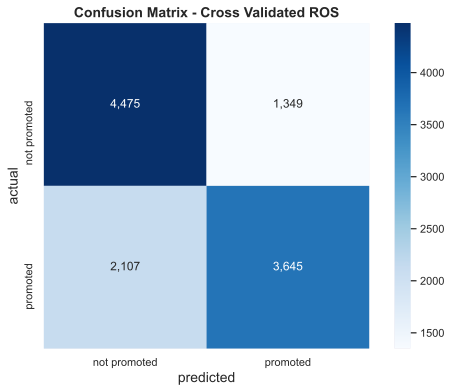

In [175]:
model_confusion = confusion_matrix(y2_val, y2_pred)

plt.figure(dpi=150)
sns.heatmap(model_confusion, cmap=plt.cm.Blues, annot=True, square=True, 
            xticklabels=['not promoted','promoted'],
            yticklabels=['not promoted','promoted'],
            fmt = ",.0f");
plt.xlabel('predicted', fontsize = 14)
plt.ylabel('actual', fontsize = 14)
plt.title('Confusion Matrix - Cross Validated ROS', fontsize = 14, fontweight = 'bold');
#plt.savefig('cm_cv_ros.pdf')

### Testing the selected model

In [176]:
df = df_ros.copy()

X = df.drop('promoted', axis = 1)
y = df['promoted']

In [177]:
#X_te.head(2)

In [178]:
# X.info()

In [179]:
X_tr_final = X2
y_tr_final = y2
X_te_final = X_te.drop(['masters_degree'], axis=1) #X_te is the hold out data features

In [180]:
#X_tr_final.head()

In [181]:
#X_te = X_te.drop(['masters_degree'], axis=1) #X_te is the hold out data features
# y_te is the holdout data

In [182]:
model_final = LogisticRegression()
model_final.fit(X_tr_final, y_tr_final)
y_pred_final = model_final.predict(X_te_final)

model_confusion = confusion_matrix(y_te, y_pred_final )
print(f"Confusion matrix:{nl}{model_confusion}")

Confusion matrix:
[[7006 2068]
 [ 312  551]]


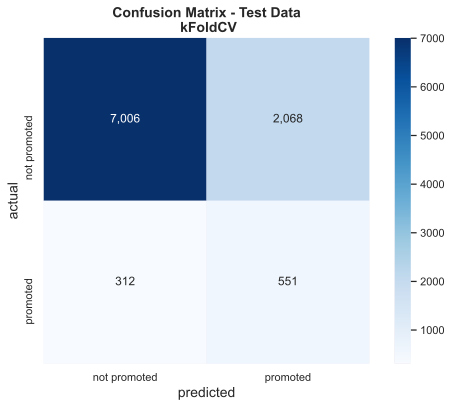

In [183]:
model_final = LogisticRegression()
model_final.fit(X_tr_final, y_tr_final)
y_pred_final = model_final.predict(X_te_final)

model_confusion = confusion_matrix(y_te, y_pred_final )

plt.figure(dpi=150)
sns.heatmap(model_confusion, cmap=plt.cm.Blues, annot=True, square=True, 
            xticklabels=['not promoted','promoted'],
            yticklabels=['not promoted','promoted'],
            fmt = ",.0f");
plt.xlabel('predicted', fontsize = 14)
plt.ylabel('actual', fontsize = 14)
plt.title('Confusion Matrix - Test Data\n kFoldCV', fontsize = 14, fontweight = 'bold');
#plt.savefig('cm_tested_kF.pdf')

In [184]:
from sklearn.metrics import precision_score, recall_score, accuracy_score
nl = '\n'
print(f" Selected model scores: {nl} \
recall  score = {metrics.recall_score(y_te, y_pred_final):.3f}{nl} \
precision     = {metrics.precision_score(y_te, y_pred_final):.3f}")

 Selected model scores: 
 recall  score = 0.638
 precision     = 0.210


The tested model is unsatisfactory with 36% promoted classified as FN and FP/TP ratio of almost 4:1

In [185]:
print(f"Intercept : {round (model_final.intercept_[0], 4)}")

Intercept : 0.3306


In [186]:
pd.DataFrame(zip(X_tr_final.columns, np.transpose(model.coef_.tolist()[0])), columns=['features', 'coef'])

,features,coef
0,gender_f,-0.012644
1,awards,1.696066
2,dept_analytics,-4.066226
3,dept_finance,-0.280012
4,dept_HR,1.431689
5,dept_legal,-0.496076
6,dept_procurement,-1.653477
7,dept_R&D,-4.446348
8,dept_sales&marketing,1.670220
9,dept_technology,-3.177854


### GridSearchCV

In [187]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.metrics import make_scorer

In [188]:
scorer = {
    'precision_score':make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score':make_scorer(accuracy_score)
}

In [189]:
param_grid = [{'penalty':['l1', 'l2'], 'class_weight':[{1:1.25}, "balanced"], 'C':[0.001, 0.01, 0.1, 1, 10, 100, 1000]}]
grid =GridSearchCV(LogisticRegression (), param_grid, cv=5, scoring = scorer, refit="recall_score", verbose = 3, n_jobs =-1)

In [190]:
#type(scorer['accuracy_score'])


In [191]:
grid.fit(X_resampled, y_resampled)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:   15.6s finished


GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid=[{'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                          'class_weight': [{1: 1.25}, 'balanced'],
                          'penalty': ['l1', 'l2']}],
             refit='recall_score',
             scoring={'accuracy_score': make_scorer(accuracy_score),
                      'precision_score': make_scorer(precision_score),
                      'recall_score': make_scorer(recall_score)},
             verbose=3)

In [192]:
grid.cv_results_

{'mean_fit_time': array([0.02264767, 0.35052786, 0.01842961, 0.23609619, 0.01261706,
        0.46010218, 0.01095037, 0.40808272, 0.01665154, 0.57802162,
        0.0161654 , 0.50823483, 0.01190009, 0.49035068, 0.01326356,
        0.4397357 , 0.01191621, 0.56342421, 0.01173644, 0.51983957,
        0.01275992, 0.66765566, 0.02755799, 0.70756359, 0.01519299,
        0.74025574, 0.02181668, 0.53243227]),
 'std_fit_time': array([0.01217071, 0.11046351, 0.00678172, 0.02534135, 0.00111783,
        0.08012915, 0.00104803, 0.05244938, 0.00599408, 0.10550254,
        0.00386905, 0.03919283, 0.0010393 , 0.03071542, 0.00171981,
        0.07325993, 0.00096175, 0.03973256, 0.00035901, 0.05216995,
        0.00162329, 0.12191713, 0.0223975 , 0.06664595, 0.00274727,
        0.04965396, 0.00428264, 0.12233127]),
 'mean_score_time': array([0.        , 0.03311734, 0.        , 0.04269896, 0.        ,
        0.02790065, 0.        , 0.03146529, 0.        , 0.02530828,
        0.        , 0.02642436, 0.      

In [193]:
grid.best_params_

{'C': 0.001, 'class_weight': {1: 1.25}, 'penalty': 'l2'}

In [194]:
final_params = grid.best_params_

In [195]:
grid_lr = LogisticRegression(**final_params)

In [196]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [197]:
grid_lr.fit(X_train, y_train)

LogisticRegression(C=0.001, class_weight={1: 1.25})

In [198]:
y_pred = grid_lr.predict(X_test)
nl = '\n'
print(f" Selected model scores: {nl} \
recall  score = {metrics.recall_score(y_test, y_pred):.3f}{nl} \
precision     = {metrics.precision_score(y_test, y_pred):.3f}")
confusion_matrix(y_test, y_pred)

 Selected model scores: 
 recall  score = 0.749
 precision     = 0.637


array([[3291, 2479],
       [1456, 4350]])

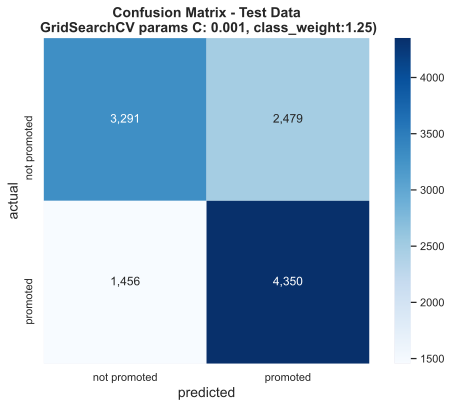

In [199]:
y_pred = grid_lr.predict(X_test)

model_confusion = confusion_matrix(y_test, y_pred )

plt.figure(dpi=150)
sns.heatmap(model_confusion, cmap=plt.cm.Blues, annot=True, square=True, 
            xticklabels=['not promoted','promoted'],
            yticklabels=['not promoted','promoted'],
            fmt = ",.0f");
plt.xlabel('predicted', fontsize = 14)
plt.ylabel('actual', fontsize = 14)
plt.title('Confusion Matrix - Test Data\n GridSearchCV params C: 0.001, class_weight:1.25)', fontsize=14, fontweight ='bold');
plt.savefig('cm_tested_GSCV.pdf')

This could not right? (TP +FN) > total employee promoted (4413)

In [200]:
grid_lr2 = LogisticRegression(**final_params)

In [201]:
grid_lr2.fit(X_train, y_train)

LogisticRegression(C=0.001, class_weight={1: 1.25})

Trying the GridSearchCV applying different weight:

In [202]:
param_grid2 = [{'penalty':['l1', 'l2'], 'class_weight':[{1:0.75}, "balanced"], 'C':[0.001,0.01, 0.1, 1, 10, 100, 1000]}]
grid2 =GridSearchCV(LogisticRegression (), param_grid2, cv=5, scoring = scorer, refit="recall_score", verbose = 3, n_jobs =-1)

In [203]:
grid2.fit(X_resampled, y_resampled)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:   10.7s finished


GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid=[{'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                          'class_weight': [{1: 0.75}, 'balanced'],
                          'penalty': ['l1', 'l2']}],
             refit='recall_score',
             scoring={'accuracy_score': make_scorer(accuracy_score),
                      'precision_score': make_scorer(precision_score),
                      'recall_score': make_scorer(recall_score)},
             verbose=3)

In [204]:
grid2.cv_results_

{'mean_fit_time': array([0.02998481, 0.292202  , 0.01996002, 0.31637015, 0.02860746,
        0.58523183, 0.01517301, 0.56581821, 0.01949916, 0.63825388,
        0.01723838, 0.66508627, 0.02143979, 0.61068702, 0.01824269,
        0.51379123, 0.01118779, 0.51417594, 0.01134496, 0.49565334,
        0.01076918, 0.49139867, 0.01202836, 0.49824319, 0.0114634 ,
        0.49755988, 0.01034498, 0.43701601]),
 'std_fit_time': array([0.02568781, 0.01901983, 0.01167671, 0.01450339, 0.02232035,
        0.06170683, 0.00895738, 0.03734851, 0.00968354, 0.10837648,
        0.00693378, 0.08759935, 0.01135316, 0.08780224, 0.01100543,
        0.08258492, 0.00277131, 0.0297392 , 0.00378918, 0.05377358,
        0.00230903, 0.06011125, 0.00294045, 0.04802582, 0.0012356 ,
        0.04844522, 0.003717  , 0.03867557]),
 'mean_score_time': array([0.        , 0.02888303, 0.        , 0.04881015, 0.        ,
        0.03358459, 0.        , 0.03274198, 0.        , 0.03671832,
        0.        , 0.03036251, 0.      

In [205]:
grid.best_params_

{'C': 0.001, 'class_weight': {1: 1.25}, 'penalty': 'l2'}

In [206]:
y_pred2 = grid_lr2.predict(X_test)
nl = '\n'
print(f" Selected model scores: {nl} \
recall  score = {metrics.recall_score(y_test, y_pred2):.3f}{nl} \
precision     = {metrics.precision_score(y_test, y_pred2):.3f}")
confusion_matrix(y_test, y_pred2)

 Selected model scores: 
 recall  score = 0.749
 precision     = 0.637


array([[3291, 2479],
       [1456, 4350]])

The same best_params_ returned  for class_weight = {1:1.25} eventhough we input different  class_weight in teh parameter grid. 